# Import library

In [1]:
import numpy as np
import random
import itertools
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import os
import pandas as pd 
import keras.metrics as metrics
from PIL import Image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chroma Feature

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32


datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_2 = datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/EE3063_PROJECT/final/data/chroma/train/",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
    )

val_2 = datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/EE3063_PROJECT/final/data/chroma/val",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=42
    )

Found 4692 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.


In [5]:
print(val_2.labels.sum())

544


# Get label name

In [6]:
image_batch, label_batch = next(val_2)
image_batch.shape, label_batch.shape

labels = '\n'.join(sorted(train_2.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

print(train_2.class_indices)

{'neg': 0, 'pos': 1}


# Get model

In [7]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained VGG16

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')
base_model.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [8]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=16, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=2, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         2359808   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 512)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               6

In [11]:
lr = 1e-4
losses = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
              loss=losses,
              metrics=metrics.AUC())

# Trainning

In [12]:
STEP_SIZE_TRAIN=train_2.n//train_2.batch_size
STEP_SIZE_VALID=val_2.n//val_2.batch_size

In [13]:
checkpoint  = ModelCheckpoint('/content/drive/MyDrive/EE3063_PROJECT/final/best_model_chroma.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_2, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_2,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 50,
                    callbacks=callbacks_list
                    )

# More train

In [19]:
STEP_SIZE_TRAIN=train_2.n//train_2.batch_size
STEP_SIZE_VALID=val_2.n//val_2.batch_size

In [ ]:
filepath = "/content/drive/MyDrive/EE3063_PROJECT/final/best_model_chroma2.h5"
new_model = load_model(filepath)

checkpoint  = ModelCheckpoint('/content/drive/MyDrive/EE3063_PROJECT/final/best_model_chroma3.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

new_model.fit_generator(train_2, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_2,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 20,
                    callbacks=callbacks_list
                    )

# Evaluation

In [26]:
filepath = "/content/drive/MyDrive/EE3063_PROJECT/final/chroma_model/best_model_chroma.h5"
new_model = load_model(filepath)

In [27]:
test_2 = datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/EE3063_PROJECT/final/data/chroma/test/",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=42
    )

Found 800 images belonging to 2 classes.


In [28]:
STEP_SIZE_TEST=test_2.n//test_2.batch_size

test_2.reset()

pred = new_model.predict_generator(test_2,
steps=STEP_SIZE_TEST,
verbose=1)

predicted=np.argmax(pred,axis=1)
y = test_2.labels

TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(y)):
  if predicted[i] == y[i]:
    if y[i] == 1: 
      TP+=1
    else:
      TN+=1
  else:
    if y[i] == 1: 
      FN+=1
    else:
      FP+=1
print('TP: ', TP)
print('TN: ', TN)
print('FN: ', FN)
print('FP: ', FP)

#precision = TP/(TP+FP)
precision = TP / (TP + FP)

#recall = TP/P
recall = TP / (TP+FN)

f1 = 2 * precision * recall / (precision + recall)

print("Precision: %.3f" % precision)
print("Recall: %.3f" % recall)
print("F1-score: %.3f" % f1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


25/25 [==============================] - 6s 242ms/step
TP:  119
TN:  549
FN:  17
FP:  115
Precision: 0.509
Recall: 0.875
F1-score: 0.643


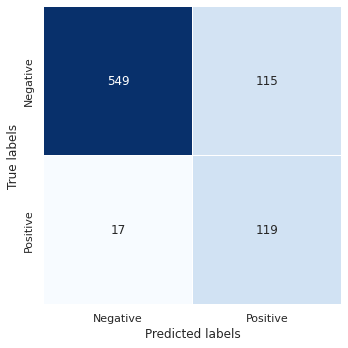

              precision    recall  f1-score   support

    Negative       0.97      0.83      0.89       664
    Positive       0.51      0.88      0.64       136

    accuracy                           0.83       800
   macro avg       0.74      0.85      0.77       800
weighted avg       0.89      0.83      0.85       800



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y, predicted)
cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])

plt.figure(figsize=(5, 5))

sns.set(font_scale=1)

ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.tight_layout()

plt.show()

print(classification_report(y, predicted, target_names=["Negative", "Positive"]))

[0.         0.17319277 1.        ] [0.    0.875 1.   ] [2 1 0]


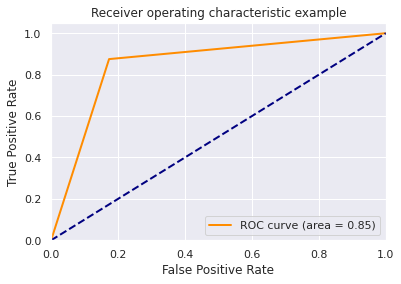

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr, tpr, thresholds = roc_curve(y, predicted, pos_label=1)
print(fpr, tpr, thresholds)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
         lw=lw, label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()